In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

In [10]:
!curl -Lo data.zip https://www.kaggle.com/api/v1/datasets/download/jeanmidev/smart-meters-in-london
!mkdir data
!unzip data.zip -d data
!rm data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1193M  100 1193M    0     0  27.6M      0  0:00:43  0:00:43 --:--:-- 32.6M   0  0:02:15  0:00:07  0:02:08 28.5M   0  0:01:06  0:00:13  0:00:53 28.6M  0  0:00:51  0:00:23  0:00:28 27.3M
Archive:  data.zip
  inflating: data/acorn_details.csv  
  inflating: data/daily_dataset.csv  
  inflating: data/daily_dataset/daily_dataset/block_0.csv  
  inflating: data/daily_dataset/daily_dataset/block_1.csv  
  inflating: data/daily_dataset/daily_dataset/block_10.csv  
  inflating: data/daily_dataset/daily_dataset/block_100.csv  
  inflating: data/daily_dataset/daily_dataset/block_101.csv  
  inflating: data/daily_dataset/daily_dataset/block_102.csv  
  inflating: data/daily_dataset/daily_dataset/block_103.csv  
  inflating: data/daily_dataset/daily_dataset/bloc

In [2]:
households = pd.read_csv("data/informations_households.csv")
acorn = pd.read_csv(
    filepath_or_buffer="data/acorn_details.csv",
    encoding="windows-1252",
)
holidays = pd.read_csv(
    filepath_or_buffer="data/uk_bank_holidays.csv",
    parse_dates=["Bank holidays"],
)
daily_weather = pd.read_csv(
    filepath_or_buffer="data/weather_daily_darksky.csv",
    parse_dates=[
        "temperatureMaxTime",
        "temperatureMinTime",
        "apparentTemperatureMinTime",
        "apparentTemperatureHighTime",
        "time",
        "sunsetTime",
        "sunriseTime",
        "temperatureHighTime",
        "uvIndexTime",
        "temperatureLowTime",
        "apparentTemperatureMaxTime",
        "apparentTemperatureLowTime",
    ],
)
hourly_weather = pd.read_csv(
    filepath_or_buffer="data/weather_hourly_darksky.csv",
    parse_dates=["time"],
)

In [4]:
daily_consumption = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/daily_dataset/daily_dataset/block_*.csv")
)
half_hourly_consumption_long = pd.concat(
    pd.read_csv(
        filepath_or_buffer=path,
        converters={
            "energy(kWh/hh)": lambda x: pd.to_numeric(arg=x.strip(), errors="coerce"),
        },
        parse_dates=["tstp"],
    )
    for path in glob.glob("data/halfhourly_dataset/halfhourly_dataset/block_*.csv")
)
half_hourly_consumption_wide = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/hhblock_dataset/hhblock_dataset/block_*.csv")
)

## Month vs. avg. monthly consumption

In [3]:
t = daily_consumption.copy()
t["year"] = t["day"].dt.year
t["month"] = t["day"].dt.month
t = t.groupby(["LCLid", "year", "month"])["energy_sum"].sum().reset_index()
t = t.groupby("month")["energy_sum"].mean()
t = t.rename("avg_monthly_consumption")
t.index.name = "month"
t

NameError: name 'daily_consumption' is not defined

Text(0, 0.5, 'Avg. monthly consumption (kWh)')

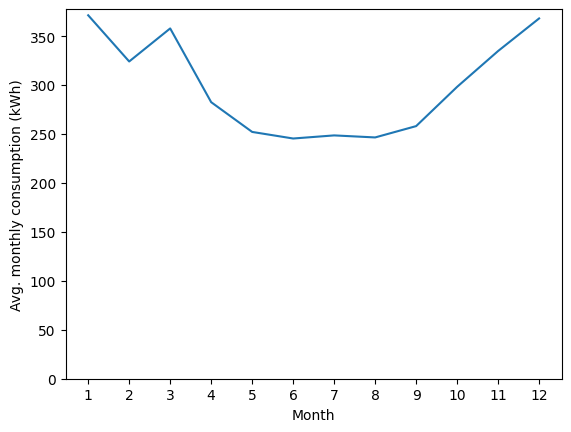

In [16]:
plt.plot(t.index, t.values)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylim(bottom=0)
plt.ylabel("Avg. monthly consumption (kWh)")

In [142]:
t = daily_consumption.copy()
t["month_day"] = t["day"].dt.strftime("%m-%d")
t = t.groupby("month_day")["energy_sum"].mean().rename("avg_consumption_by_day_of_year")

t.index = pd.to_datetime("2000-" + t.index)
t = t.sort_index()
t

month_day
2000-01-01    12.076920
2000-01-02    11.677095
2000-01-03    11.491718
2000-01-04    11.734618
2000-01-05    12.169915
                ...    
2000-12-27    11.746924
2000-12-28    11.588834
2000-12-29    11.830009
2000-12-30    11.879304
2000-12-31    11.927044
Name: avg_consumption_by_day_of_year, Length: 366, dtype: float64

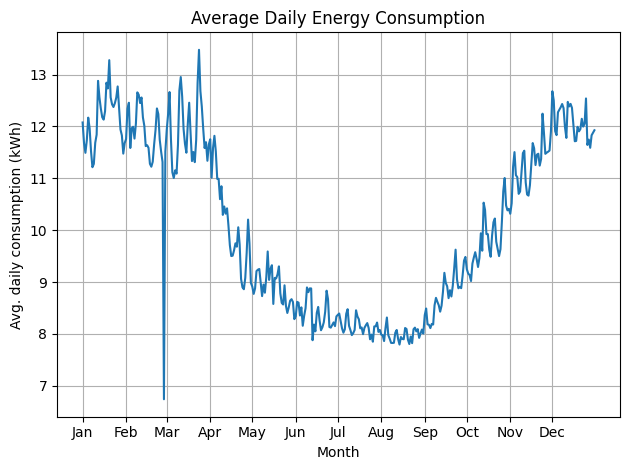

In [143]:
plt.plot(t.index, t.values)
plt.title("Average Daily Energy Consumption")
plt.ylabel("Avg. daily consumption (kWh)")
plt.xlabel("Month")
start = pd.date_range("2000-01-01", "2000-12-31", freq="MS")
label = [date.strftime("%b") for date in month_starts]

plt.xticks(start, label)
plt.grid(True)
plt.tight_layout()
plt.show()

## Daily max temp vs. avg. daily consumption (2013)

In [24]:
t = daily_consumption.copy()[daily_consumption["day"].dt.year == 2013]
t["day_of_year"] = t["day"].dt.dayofyear
t = t.groupby("day_of_year")["energy_sum"].mean().reset_index()
r = daily_weather.copy()[daily_weather["temperatureMaxTime"].dt.year == 2013]
r["day_of_year"] = r["temperatureMaxTime"].dt.dayofyear
r = r.filter(["day_of_year", "temperatureMax"])
t = t.merge(right=r, on="day_of_year").set_index("day_of_year")
t.columns = ["avg_daily_consumption", "daily_max_temp"]
t

,avg_daily_consumption,daily_max_temp
day_of_year,,
1,11.839174,7.49
2,12.016655,10.82
3,11.399221,11.41
4,11.417020,10.79
5,11.709836,10.66
...,...,...
361,11.661978,10.99
362,11.379026,7.81
363,11.973593,7.56


In [25]:
a, b, c = np.polyfit(x=t["daily_max_temp"], y=t["avg_daily_consumption"], deg=2)
a, b, c

(0.006321807485330998, -0.42020231234008915, 14.43016472206293)

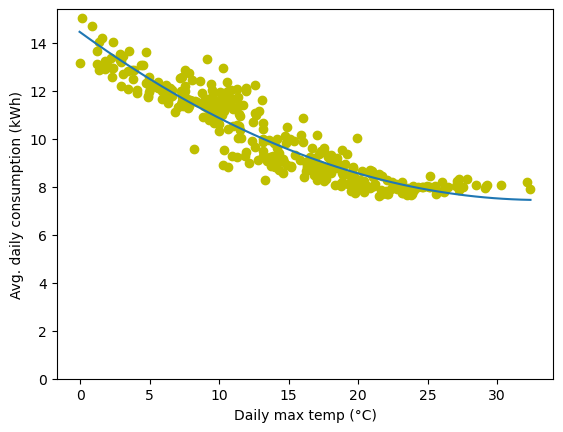

In [26]:
plt.scatter(x=t["daily_max_temp"], y=t["avg_daily_consumption"], color="y")
x = np.linspace(t["daily_max_temp"].min(), t["daily_max_temp"].max())
plt.plot(x, a * x ** 2 + b * x + c)
plt.xlabel("Daily max temp (°C)")
plt.ylim(bottom=0)
plt.ylabel("Avg. daily consumption (kWh)");

In [28]:
metrics.r2_score(
    t["avg_daily_consumption"],
    a * t["daily_max_temp"] ** 2 + b * t["daily_max_temp"] + c,
)

0.8736873691696522

## Hour vs. avg. hourly consumption

In [17]:
t = half_hourly_consumption_long.copy()
t = t[t["energy(kWh/hh)"].notna()]
t["date"] = t["tstp"].dt.date
t["hour"] = t["tstp"].dt.hour
t = t.groupby(["LCLid", "date", "hour"])["energy(kWh/hh)"].sum().reset_index()
t = t.groupby("hour")["energy(kWh/hh)"].mean().rename("avg_hourly_consumption")
t

hour
0     0.347602
1     0.289939
2     0.249546
3     0.231265
4     0.228955
5     0.251458
6     0.314518
7     0.385446
8     0.426915
9     0.431469
10    0.427858
11    0.428273
12    0.432695
13    0.428642
14    0.420943
15    0.432359
16    0.482747
17    0.562428
18    0.624086
19    0.641612
20    0.625569
21    0.587606
22    0.508431
23    0.401510
Name: avg_hourly_consumption, dtype: float64

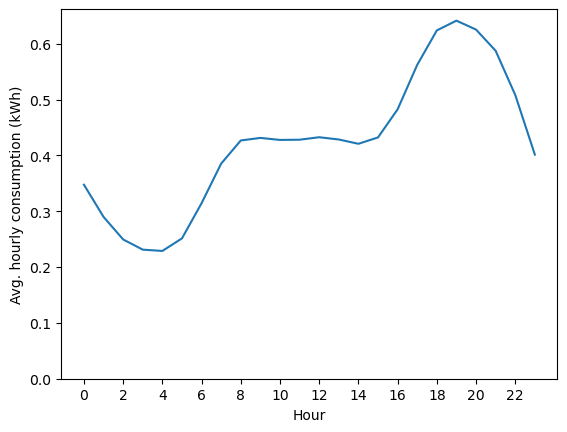

In [22]:
plt.plot(t.index, t.values)
plt.xticks(range(0, 24, 2))
plt.xlabel("Hour")
plt.ylim(bottom=0)
plt.ylabel("Avg. hourly consumption (kWh)");

## Acorn group vs. avg. daily consumption

In [47]:
t = daily_consumption.copy().merge(right=households, on="LCLid")
t = t[t["Acorn"].str.fullmatch("ACORN-[A-Q]")].groupby("Acorn")["energy_sum"]
t = t.mean().rename("avg_daily_consumption")
t.index = t.index.str.replace("ACORN-", "")
t.index.name = "acorn_group"
t

acorn_group
A    19.063876
B    11.902597
C    11.950990
D    13.578131
E    10.353099
F     9.191454
G    10.169360
H    11.007658
I     9.439643
J    11.347921
K    10.006530
L    10.028332
M     9.987455
N     9.218043
O     8.528726
P     6.611038
Q     7.564822
Name: avg_daily_consumption, dtype: float64

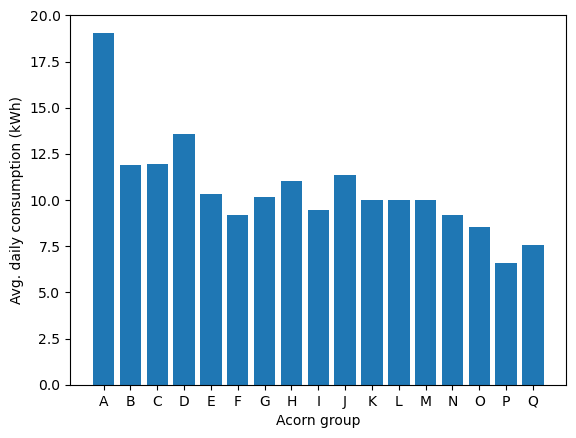

In [48]:
plt.bar(t.index, t.values)
plt.xlabel("Acorn group")
plt.ylabel("Avg. daily consumption (kWh)");

## Three Acorn groups

In [133]:
t = pd.merge(daily_consumption, households, on="LCLid")  
t = t[t["Acorn_grouped"] != "ACORN-"]  
t = t[t["Acorn_grouped"] != "ACORN-U"]  
r = t.groupby("Acorn_grouped")["energy_sum"].mean().rename("avg_daily_consumption").reindex(["Affluent", "Comfortable", "Adversity"])  
r  

Acorn_grouped
Affluent       11.478613
Comfortable    10.004460
Adversity       8.503382
Name: avg_daily_consumption, dtype: float64

Text(0, 0.5, 'Avg. daily consumption (kWh)')

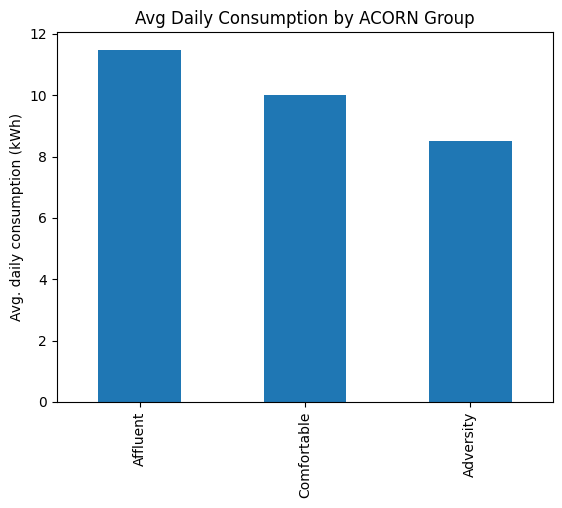

In [134]:
chart = r.plot(kind="bar", title="Avg Daily Consumption by ACORN Group")  
chart.set_xlabel("")  
chart.set_ylabel("Avg. daily consumption (kWh)")

## Acorn groups monthly comparison

In [135]:
t = pd.merge(daily_consumption, households, on="LCLid")

t = t[t["Acorn_grouped"].isin(["Affluent", "Comfortable", "Adversity"])]
t["year"] = t["day"].dt.year
t["month"] = t["day"].dt.month

t.groupby(["Acorn_grouped", "LCLid", "year", "month"])["energy_sum"].sum()
t.reset_index()

t = (
    t.groupby(["Acorn_grouped", "month"])["energy_sum"]
    .mean()
    .unstack("Acorn_grouped")
    .rename_axis("month")
)
t

Acorn_grouped,Adversity,Affluent,Comfortable
month,,,
1,9.896382,14.140512,11.867165
2,9.585557,13.595137,11.476638
3,9.759187,13.658552,11.684465
4,8.585774,11.458217,9.848121
5,7.632033,9.990674,8.691085
6,7.269626,9.366113,8.252019
7,7.205554,8.857854,8.205561
8,7.095217,8.588027,8.057627
9,7.489959,9.808937,8.668641


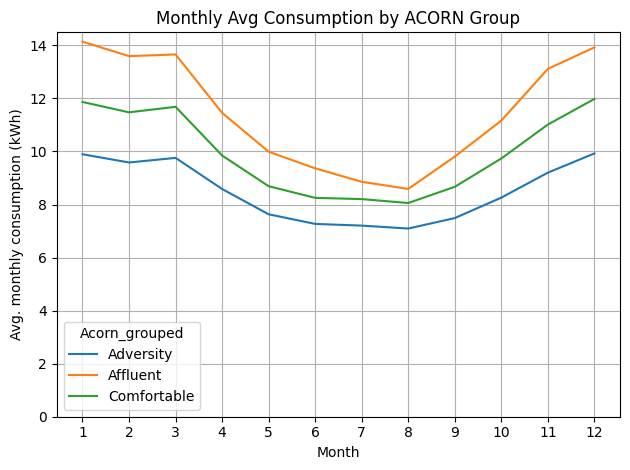

In [136]:
t.plot(title="Monthly Avg Consumption by ACORN Group")
plt.xlabel("Month")
plt.ylabel("Avg. monthly consumption (kWh)")
plt.xticks(range(1, 13))
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()

## Holiday impact

In [17]:
t = daily_consumption.copy()  
t["is_holiday"] = t["day"].isin(holidays["Bank holidays"])  
r = t.groupby("is_holiday")["energy_sum"].mean().rename(index={True: "Holiday", False: "No holiday"})  
r  

is_holiday
No holiday    10.117362
Holiday       10.412623
Name: energy_sum, dtype: float64

Text(0, 0.5, 'Avg. daily consumption (kWh)')

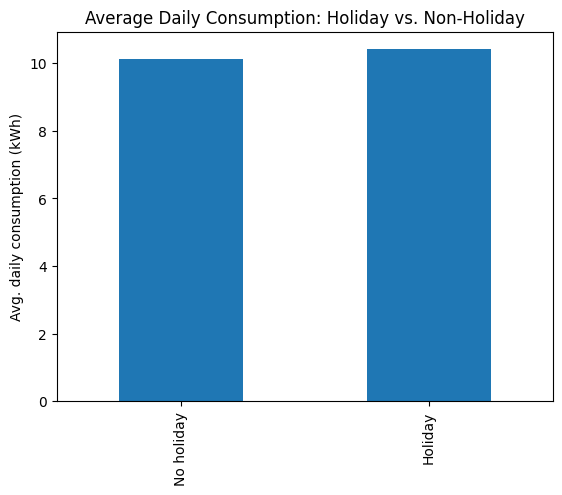

In [18]:
chart = r.plot(kind="bar", title="Average Daily Consumption: Holiday vs. Non-Holiday")  
chart.set_xlabel("")  
chart.set_ylabel("Avg. daily consumption (kWh)")

## Weekdays and weekends

In [20]:
t = daily_consumption.copy()  
t["weekday"] = t["day"].dt.dayofweek  
t["is_weekend"] = t["weekday"] >= 5  
r = t.groupby("is_weekend")["energy_sum"].mean().rename(index={False: "Weekday", True: "Weekend"})  
r  

is_weekend
Weekday     9.987462
Weekend    10.467837
Name: energy_sum, dtype: float64

Text(0, 0.5, 'Avg. daily consumption (kWh)')

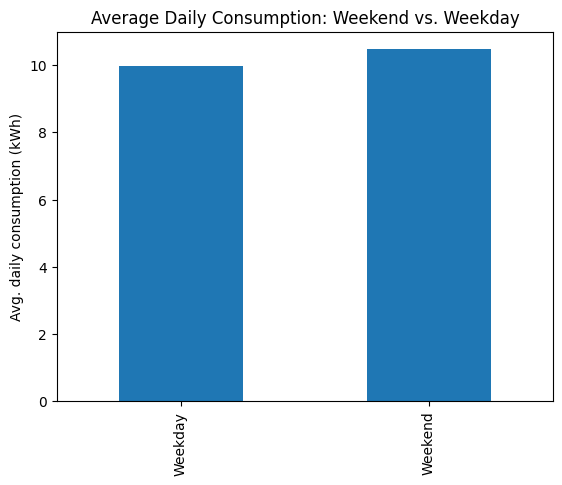

In [21]:
chart = r.plot(kind="bar", title="Average Daily Consumption: Weekend vs. Weekday")  
chart.set_xlabel("")  
chart.set_ylabel("Avg. daily consumption (kWh)")

## Average energy usage by hour and day of the week

In [149]:
t = half_hourly_consumption_long.copy()
t["hour"] = t["tstp"].dt.hour
t["weekday"] = t["tstp"].dt.dayofweek

r = t.groupby(["weekday", "hour"])["energy(kWh/hh)"].mean().unstack("hour").values
r


array([[0.17082509, 0.14252202, 0.12307361, 0.11420959, 0.11378002,
        0.12655476, 0.16195108, 0.20088215, 0.21711212, 0.21294192,
        0.20889071, 0.20706661, 0.20944203, 0.20694121, 0.20285804,
        0.20972119, 0.23724268, 0.28177728, 0.31714706, 0.32880197,
        0.32208698, 0.30204767, 0.25722174, 0.19804187],
       [0.16975696, 0.14180497, 0.12282331, 0.11446295, 0.11442757,
        0.12814362, 0.16530107, 0.20257964, 0.21536631, 0.20797454,
        0.2021258 , 0.2005223 , 0.20133487, 0.19956437, 0.19733771,
        0.20460758, 0.23395539, 0.27786962, 0.31246169, 0.32467666,
        0.31811216, 0.29883153, 0.25567303, 0.19799016],
       [0.17017767, 0.14206505, 0.12287161, 0.11469313, 0.1144935 ,
        0.12822158, 0.16548507, 0.20368803, 0.21687482, 0.209418  ,
        0.20300869, 0.20151097, 0.20274782, 0.2010475 , 0.19830558,
        0.20536663, 0.23220709, 0.27467321, 0.30920879, 0.32169409,
        0.31627211, 0.29761548, 0.25611293, 0.19969031],
       [0.171

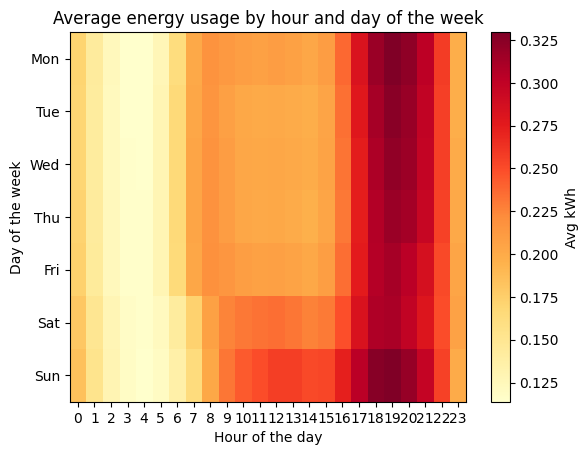

In [153]:
plt.imshow(r, aspect="auto", cmap="YlOrRd")

plt.title("Average energy usage by hour and day of the week")
plt.xlabel("Hour of the day")
plt.ylabel("Day of the week")

plt.xticks(ticks=np.arange(0, 24), labels=[str(h) for h in range(24)])
plt.yticks(ticks=np.arange(0, 7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

plt.colorbar(label="Avg kWh")
plt.show()

## Machine learning model to predict acorn group

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

First, we create a clean dataset by merging the daily_consumption and households data. We include only the three target ACORN groups: affluent, comfortable, and adversity. Then we extract the month and day of the week from the date column to use as inputs.

In [25]:
groups = pd.merge(daily_consumption, households, on="LCLid")

groups = groups[groups["Acorn_grouped"].isin(["Affluent", "Comfortable", "Adversity"])]
groups["day_of_week"] = groups["day"].dt.dayofweek
groups["month"] = groups["day"].dt.month
# groups

Now we will choose the input and target columns for our model. For the input we chose the columns that we found to be most relevent to the prediction.

In [26]:
# input columns
X = groups[["energy_mean", "energy_std", "energy_min", "energy_max", "energy_sum", "month", "day_of_week", "energy_count"]]

# target column
y = groups["Acorn_grouped"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Then we prepare the data by scaling the input features using StandardScaler so that all values are on a similar scale. Then we split the data into a training set and a test set, so we can train the model on one part and use the other to test the model. We also convert the target labels into one-hot encoded format, which is mandatory for multi-class classification with a neural network.

In [27]:
# normalize input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# one-hot encode labels
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

We build a neural network model with two hidden layers, using relu as the activation function.

In [ ]:
# Build the neural network
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# training the model (takes a lot of time for 20 epochs, we can decrease for speed)
model.fit(X_train, y_train_cat, epochs=5, validation_data=(X_test, y_test_cat))

Epoch 1/5
87003/87003 ━━━━━━━━━━━━━━━━━━━━ 54s 607us/step - accuracy: 0.3261 - loss: nan - val_accuracy: 0.3258 - val_loss: nan
Epoch 2/5
87003/87003 ━━━━━━━━━━━━━━━━━━━━ 53s 604us/step - accuracy: 0.3262 - loss: nan - val_accuracy: 0.3258 - val_loss: nan
Epoch 3/5
87003/87003 ━━━━━━━━━━━━━━━━━━━━ 62s 716us/step - accuracy: 0.3266 - loss: nan - val_accuracy: 0.3258 - val_loss: nan
Epoch 4/5
87003/87003 ━━━━━━━━━━━━━━━━━━━━ 69s 787us/step - accuracy: 0.3269 - loss: nan - val_accuracy: 0.3258 - val_loss: nan
Epoch 5/5
87003/87003 ━━━━━━━━━━━━━━━━━━━━ 74s 845us/step - accuracy: 0.3266 - loss: nan - val_accuracy: 0.3258 - val_loss: nan


In [15]:
# testing performance
loss, accuracy = model.evaluate(X_test, y_test_cat)
print("Accuracy:", accuracy)

21751/21751 ━━━━━━━━━━━━━━━━━━━━ 9s 397us/step - accuracy: 0.3259 - loss: nan
Accuracy: 0.32578372955322266
